# Testing photobleaching model 

In [6]:
import numpy as np
import pandas as pd
import bokeh.io
import bokeh.plotting
import mscl_utils as mscl
import scipy.signal
import mscl_mcmc as msmc
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
%matplotlib inline
bokeh.io.output_notebook()

Loading BokehJS ...

In this notebook, I will describe a heirarchical statistical model for photobleaching and test it out on simulated data. The model developed here is used to correct for signal loss due to photobleaching during the dilution experiment.  

## The problem 

In generall, photobleaching is an
$$
I(t) = \beta_0 + I_0 \exp\left[{-t \over \tau}\right]
$$

In [183]:
# Set the simulation parameters
np.random.seed(14)
n_cells = 6 
time = np.arange(0, 500, 1)
beta_opt, I0_opt, tau_opt = 1000, 8000, 100
beta_seed = np.random.normal(loc=beta_opt, scale=20, size=n_cells)
I0_seed = np.random.normal(loc=I0_opt, scale=4000, size=n_cells)
tau_seed = np.random.normal(loc=tau_opt, scale=10, size=n_cells)

def exp_decay(params, time, noise):
    beta, I0, tau = params
    return beta + I0 * np.exp(-time/tau) + noise

# Perform the simulation and store as a dataframe.
df = pd.DataFrame([], columns=['cell_number', 'I_t', 'time'])
for i in range(n_cells):
    noise = np.random.normal(loc=0, scale=450, size=len(time))
    sim = exp_decay((beta_seed[i], I0_seed[i], tau_seed[i]), time, noise)
    _df = pd.DataFrame([sim, time]).T
    _df.columns = ['I_t', 'time'] 
    _df.insert(0, 'cell_number', i) 
    df = df.append(_df, ignore_index=True)

As is typically the case, we can look at our simulated data to see if it makes sense. 

In [184]:
p = mscl.bokeh_boiler(width=700, height=600, x_axis_label='[time]',
                      y_axis_label='intensity')

# Plot each trace individually
grouped = df.groupby('cell_number')
for g, d in grouped:
    p.line(d['time'], d['I_t'], color='slategray', alpha=0.5, legend='simulated data')
    p.circle(d['time'], d['I_t'], color='slategray', alpha=0.5) 
bokeh.io.show(p)

The data looks as is expected. Note the large degree of noise in the measurement. To get a better sense of what a single cell would look like, we can take a look at a single trace

In [170]:
# Look at just one trace
cell_ind = 3
single_cell = df.loc[df['cell_number']==cell_ind]

# Compute the "true" curve without the noise.
time_range = np.linspace(0, 500, 1000)
true_trace = beta_seed[cell_ind] + I0_seed[cell_ind] *\
                np.exp(-time_range / tau_seed[cell_ind])

# Set up the figure axis.
p = mscl.bokeh_boiler(width=700, height=600,
                      x_axis_label='[time]', y_axis_label='intensity')

# Plot the data and the true curve.
p.circle(single_cell['time'], single_cell['I_t'], color='slategray', alpha=0.5,
        legend='simulated data')
p.line(single_cell['time'], single_cell['I_t'], color='slategray', alpha=0.5)
p.line(time_range, true_trace, color='tomato', line_width=2, legend='true bleaching curve')

# Show it in the notebook.
bokeh.io.show(p)

Since our simulated data passes the smell test, we can take a pass at inferring the relevant parameter values.  

## Approach I: Fitting to an average trajectory

There are three "reasonable" approaches to take for this experiment. The first is to compute the average trace from all cells and estimate the parameters to that average. 


In [171]:
# Compute average.
grouped = df.groupby(['time']).mean()
avg_df = grouped.reset_index()

# Plot it over all of the others.
p = mscl.bokeh_boiler(width=800, height=700, x_axis_label='[time]',
                     y_axis_label='intensity')
p.circle(df['time'], df['I_t'], color='slategray', alpha=0.5, legend='simulated data')
p.circle(avg_df['time'], avg_df['I_t'], color='dodgerblue', legend='averaged trace')
p.line(avg_df['time'], avg_df['I_t'], color='dodgerblue')
bokeh.io.show(p)

Now perform the MCMC for the three parameters. 

In [172]:
with pm.Model() as model:
    # Define the priors. 
    beta = pm.Uniform('beta', lower=0, upper=1E6)
    I0 = pm.Uniform('I0', lower=0, upper=1E6)
    tau = msmc.Jeffreys('tau', lower=1E-3, upper=1E6)
    
    # Evaluate the expected value.
    time = avg_df['time'].values
    mu = beta + I0 * tt.exp(-time / tau)
    
    #Define the likelihoood and sample.
    obs = avg_df['I_t'].values
    like = msmc.MarginalizedNormal('like', mu=mu, observed=obs)
    trace = pm.sample(draws=1000, tune=5000, njobs=6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:13<00:00, 440.98it/s]


{'beta': 1.0006815376006086, 'I0': 0.99997992605509989, 'tau': 1.0007557247208241}


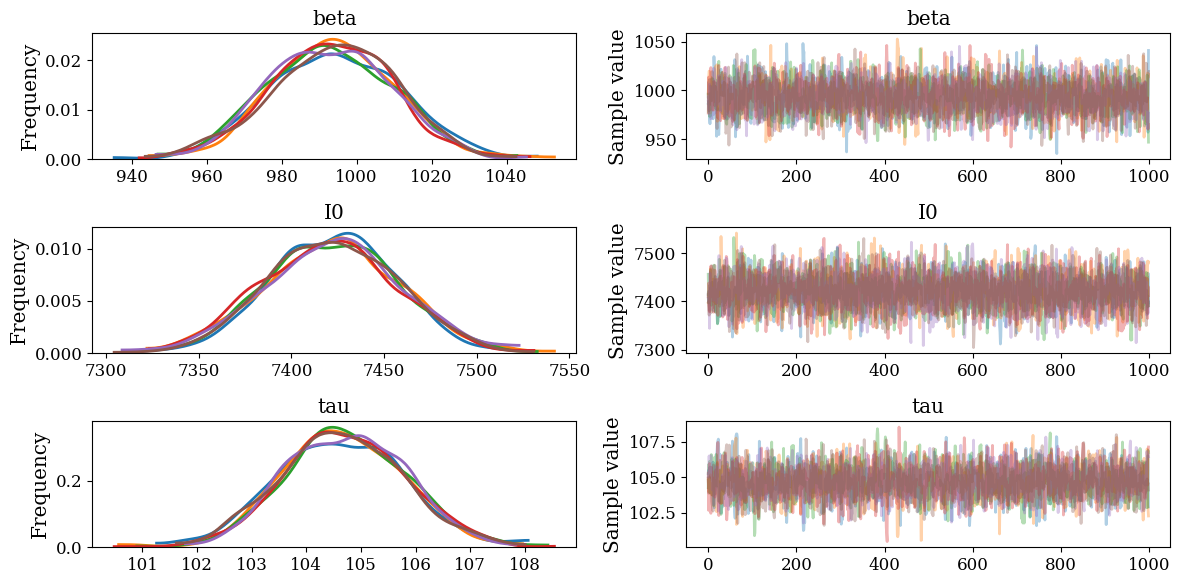

In [173]:
# Check convergence.
print(pm.gelman_rubin(trace))
_ = pm.traceplot(trace)

In [174]:
# Compute the modes. 
avg_mcmc_df = pm.trace_to_dataframe(trace)
avg_mcmc_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(avg_mcmc_df['logp'])
modes = avg_mcmc_df.iloc[ind]

In [182]:
time_range = np.linspace(0, len(time), 800)
cred_region = np.zeros((2, len(time)))
for i, t in enumerate(time):
    bleach = exp_decay(avg_mcmc_df.loc[:,['beta', 'I0', 'tau']].T.values, t, 0)
    cred_region[:, i] = mscl.hpd(bleach, mass_frac=0.95)

In [191]:
# Plot the average trace, the true bleaching constant, and the fit. 
true_trace =  exp_decay((beta_opt, I0_opt, tau_opt), time_range, 0)
mcmc_trace = exp_decay(modes[['beta', 'I0','tau']].values, time_range, 0)
p = mscl.bokeh_boiler(width=800, height=700, x_axis_label='[time]',
                     y_axis_label='signal')

p.circle(df['time'], df['I_t'], color='slategray', alpha=0.5, legend='simulated data')
p.circle(avg_df['time'], avg_df['I_t'], color='seagreen', alpha=0.75, legend='averaged data')
p.line(time_range, mcmc_trace, color='dodgerblue', line_width=4, legend='via MCMC')
p.line(time_range, true_trace, color='tomato', line_width=3, legend='"true" trace')
bokeh.io.show(p)

##  Approach II: Fitting to individual trajectories

In [223]:
# Group by cell number.
grouped = df.groupby('cell_number')
modes = pd.DataFrame([], columns=['cell_id', 'beta', 'I0', 'tau'])
with pm.Model() as model:
    # Define the priors.
    beta = pm.Uniform('beta', lower=0, upper=1E6, shape=n_cells)
    I0 = pm.Uniform('I0', lower=0, upper=1E6, shape=n_cells)
    tau = msmc.Jeffreys('tau', lower=1E-3, upper=1E3, shape=n_cells)
    
    # Compute the expected value.
    inds = df['cell_number'].values.astype(int)
    time = df['time'].values
    theo = beta[inds] + I0[inds] * tt.exp(-time / tau[inds])
    
    # Define the likelihood.
    like = msmc.MarginalizedNormal('like', mu=theo, observed=df['I_t'].values)
    
    # Sample
    trace = pm.sample(draws=5000, tune=1000, njobs=4)
    
    # Congeal the dataframe and append
    indiv_df = pm.trace_to_dataframe(trace)
    indiv_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
    ind = np.argmax(indiv_df['logp'])
#     if type(ind) is not int:
#         ind = ind[0]
    modes = pd.DataFrame(indiv_df.iloc[ind]).T.drop('logp', axis=1)
#     _modes.insert(0, 'cell_id', g)
#     modes = modes.append(_modes, ignore_index=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 6000/6000 [00:36<00:00, 164.88it/s]


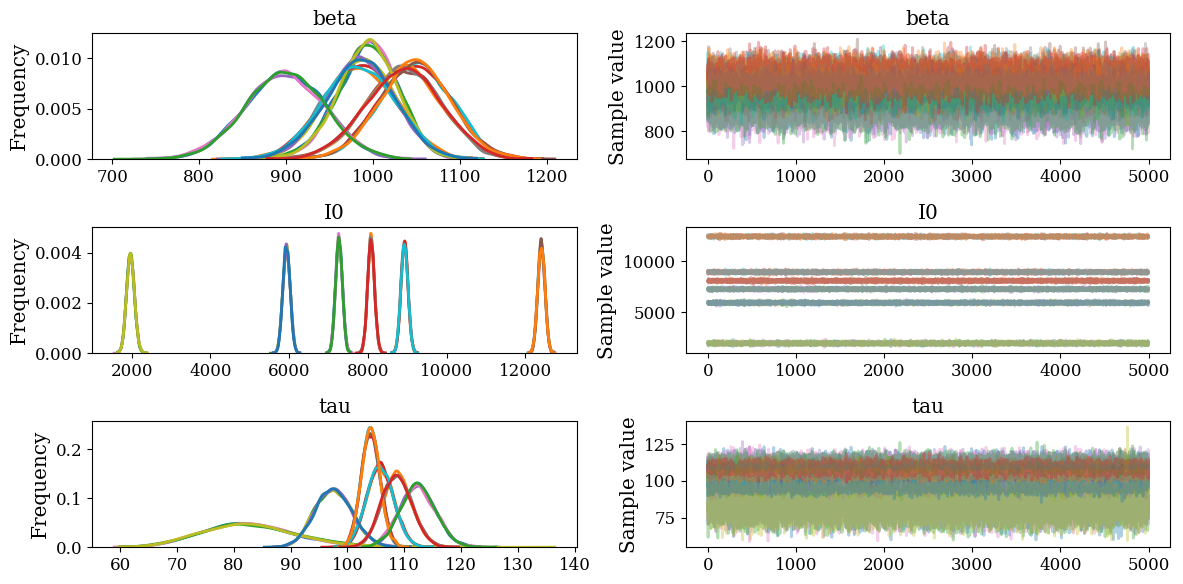

In [224]:
_ = pm.traceplot(trace)

In [226]:
# Congeal the dataframe and append
indiv_df = pm.trace_to_dataframe(trace)
indiv_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(indiv_df['logp'])
modes = indiv_df.iloc[ind]
modes
#     _modes.insert(0, 'cell_id', g)
#     modes = modes.append(_modes, ignore_index=True)

beta__0      991.481446
beta__1      967.180240
beta__2      987.080829
beta__3     1046.011108
beta__4      906.918633
beta__5     1058.959927
I0__0       1878.139090
I0__1       8905.480112
I0__2       5914.411688
I0__3      12348.055890
I0__4       7250.775651
I0__5       8038.870101
tau__0        86.532475
tau__1       107.427366
tau__2        96.879043
tau__3       104.600409
tau__4       112.624388
tau__5       108.735288
logp      -30375.732524
Name: 14710, dtype: float64

Plot each fit against each individual trace

In [230]:
canvases = [[], []]
grouped = df.groupby('cell_number')
_modes = modes.to_dict()
for g, d in grouped:
    # Compute the true trace and fit trace.
    true_trace = exp_decay((beta_seed[g], I0_seed[g], tau_seed[g]), time_range, 0)
#     cell_modes = modes.loc[modes['cell_id']==g]

    mcmc_trace = exp_decay((_modes['beta__{0}'.format(g)],_modes['I0__{0}'.format(g)],
                                   _modes['tau__{0}'.format(g)]), time_range, 0)
   
    # Set up the figure
    p = mscl.bokeh_boiler(width=300, height=300, title='cell {0}'.format(g))
    p.circle(d['time'], d['I_t'], color='slategray', alpha=0.5) 
    p.line(time_range, true_trace, line_width=3, color='tomato')
    p.line(time_range, mcmc_trace, line_width=2, color='dodgerblue')
    
    if g < 3:
        canvases[0].append(p)
    else:
        p.xaxis.axis_label = '[time]'
        canvases[1].append(p)
        
# Show the grid plot
layout = bokeh.layouts.gridplot(canvases)
bokeh.io.show(layout)

Of course, this represents each trace individually well. 

## Approach III: A heirarchical model

In [234]:
# Make a new dataframe with some smoothed data included.
with pm.Model() as model:
    # Set the top level hyperpriors.
    tau_mu = pm.Uniform('tau_mu', lower=1E-3, upper=1E3)
#     tau_sig = msmc.Jeffreys('tau_sig', lower=1E-3, upper=1E3)
    beta_mu = pm.Uniform('beta_mu', lower=0, upper=1E6)
#     beta_sig = msmc.Jeffreys('beta_sig', lower=1E-3, upper=1E6)

    # Set the lower level priors.
    tau = pm.Normal('tau', mu=tau_mu, sd=100, shape=n_cells)
    beta = pm.Normal('beta', mu=beta_mu, sd=100, shape=n_cells)
    I0 = pm.Uniform('I0', lower=0, upper=1E6, shape=n_cells)
    
    # Get the ID's and other observables
    ids = df['cell_number'].values.astype(int)
    time = df['time'].values.astype(float)
    obs = df['I_t'].values.astype(float)
    
    # Compute the expected value.
    theo = beta[ids] + I0[ids] * tt.exp(-time / tau[ids])
    
    # Set the likelihood.
    like = msmc.MarginalizedNormal('like', mu=theo, observed=obs) 


In [ ]:
# Now, sample
with model: 
    trace = pm.sample(draws=1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [ ]:
_ = pm.traceplot(trace)

In [ ]:
import pickle
with open('heirarchical_bleaching.txt', 'wb') as f:
    pickle.dump(trace, f)
    f.close()

In [ ]:
# Compute the modes.
hyper_df = pm.trace_to_dataframe(trace)
hyper_df['logp'] = pm.stats._log_post_trace(trace, model).sum(axis=1)
ind = np.argmax(hyper_df['logp'])[0]
hyper_modes = hyper_df.iloc[ind]

In [ ]:
# Plot the theo.
